## GeometricErrors - Point Shifting 

For KDD 2021

### Part 1: Loading Data

In [1]:
""" Environment Configuration """

# Source of input tensors. 
data_path = '/data/GeometricErrors/EM'

# Source of original rasters, shapefiles.
source_path ='/data/GeometricErrors/Scene01'

# Label of dataset used (Original = 1, New = 2)
dataset_label = 1

# Path to save EM Test as folder
out_root_dir = '/data/GeometricErrors/tests'

# Enables training with GPU
use_gpu = True
gpus = ['/gpu:0', '/gpu:1', '/gpu:2', '/gpu:3']

# Environment Seeds
tf_seed = 2001 # Tensorflow
np_seed = 2001 # Numpy
py_seed = 2001 # Python

# Pre-Load Determiner.
preload = False
#   ^^^
# - True, the candidates are loaded and stored. 
# - False, the candidates are loaded from jupyter persistent storage




# Weights to load when skipping training
std_weight_path = '/data/GeometricErrors/tests/BaselineWeights.h5'


""" Point Shifting Annotator Configuration """

# number of points to generate on BOTH sides of each source point
pairs = 15

# Interval at which shifting vertices are sampled in meters
interval = 10

# Offset distance between coordinate points as they are generated on either side of the source. (meters)
off_dist = 1.5

# Minimum Valid Proability over map
min_probability = 1e-06

# Weight consideration candidate0 line distance between candidate points
length_weight_value = 0

# Buffer in meters to apply to candidates
weight_buffer = 2

buff_dist = 4
# Option to normalize over K^2 (True) or by K (False).
normalize_full = False


""" UNET Config """

# Base learning rate to use in training. Reccomend 0.01
learning_rate = 0.1




""" EM Iteration Config """

# Initial jump-start predicted class map path
seg_class_map_fp = '/data/pmap.tif'

# Number of EM iterations
em_target = 6


# Learning Rate Scheduler
import lib.K_Tools as kt 
lr_schedule = kt.Oscillate_LR

# Optionally Enable notes
prompt_notes = False


/home/jiang-ws1/.virtualenvs/geo_errors/lib/python3.7/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
# Std Imports
import os, sys, time, random, csv
from datetime import datetime as dt 

# Module Imports
import tensorflow as tf
import numpy as np
import rasterio as rio
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.geometry as shp
from tensorflow.keras.optimizers import Adam

# Lib imports
import lib.Doc_Tools as doc
import lib.GeoTools as gt
import lib.Tiling as tile
import lib.K_Tools as kt
from lib.Annotators import *

from lib.models.DeepLabV2 import *
""" Static Configuration """
# Batch size for training
batch_size = 32
# Early Stopping Patience
es_patience = 20
# Reduce Learning Rate on Plateau: Multiplier to reduce LR by upon plateau
rlop_factor = 0.5
# Adam Optimizer config
adam_epsilon = 1e-8
adam_decay = 1e-5
# Buffer in meters applied to annotations when comparing iou
iou_buffer = 6

# Seed environment
random.seed(py_seed)
tf.random.set_seed(tf_seed)
np.random.seed(np_seed)

# Prompt for notes on test
if prompt_notes:
    test_notes = input("Enter Notes for test: ")
else:
    test_notes = 'Notes have been disabled.'
    
### Create Folder for test documentation
test_idx, test_dir = doc.InitTest(out_root_dir,
                                  em_target=em_target,
                                  LR=learning_rate,
                                  notes=test_notes,
                                  pairs=pairs,
                                  interval=interval,
                                  off_distance=off_dist,
                                  min_p=min_probability,
                                  L=length_weight_value)

### Loading Source
train_raster = rio.open('{}/train_raster.tif'.format(source_path))
test_raster = rio.open('{}/test_raster.tif'.format(source_path))
template_raster = rio.open('{}/template_map.tif'.format(source_path))

gt_labels = gpd.read_file('{}/GroundTruth.shp'.format(source_path))
imp_labels = gpd.read_file('{}/imperfectLines.shp'.format(source_path))

### Loading Tensors
X_train = np.load('{}/X_train.npy'.format(data_path))
Y_train = np.load('{}/Y_train.npy'.format(data_path))

X_val = np.load('{}/X_val.npy'.format(data_path))
Y_val = np.load('{}/Y_val.npy'.format(data_path))

X_test = np.load('{}/X_test.npy'.format(data_path))
Y_test = np.load('{}/Y_test.npy'.format(data_path))


### Loading tile offsets
train_offsets_fp = '{}/train_offsets.csv'.format(data_path)
val_offsets_fp = '{}/val_offsets.csv'.format(data_path)
print("Successfully loaded tensors.")

# Convert All CRS's
imp_labels = imp_labels.to_crs(train_raster.crs)
gt_labels = gt_labels.to_crs(imp_labels.crs)
source_annotation = imp_labels

### Evaluate original Shapefile Precision
source_iou = gt.gdf_iou(gt_labels, imp_labels, iou_buffer)
prev_iou = source_iou

### Create A distributed training strategy for GPU training
if use_gpu:
    mirror_strategy = tf.distribute.MirroredStrategy(devices=gpus)

Successfully loaded tensors.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [3]:
weight_buffer = 4

### Part 1: Baseline Model Training and Evaluation


*** Building DeepLabv3Plus Network ***
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Baseline Preformance:
Training Report 00
 - F1_Score: 33.258
 - Dice_Score: 33.258
 - False_Positives: 181270600.000
 - False_Negatives: 705692300.000
 - Precision: 26.873
 - Recall: 43.621
 - Keras_Precision: 44.480
 - Keras_Recall: 17.067
Validation Report 00
 - F1_Score: 30.759
 - Dice_Score: 30.758
 - False_Positives: 11059700.000
 - False_Negatives: 43624900.000
 - Precision: 25.275
 - Recall: 39.281
 - Keras_Precision: 42.030
 - Keras_Recall: 15.527
Testing Report 00
 - F1_Score: 39.313
 - Dice_Score: 39.314
 - False_Positives: 12043600.000
 - False_Negatives: 7418500.000
 - Precision: 34.358
 - Recall: 45.938
 - Keras_Precision: 34.358
 - Keras_Recall: 45.938
 - Confusion Matrix: [[9777541  120436]
 [  74185   63038]]



Mon at 11:02:52PM


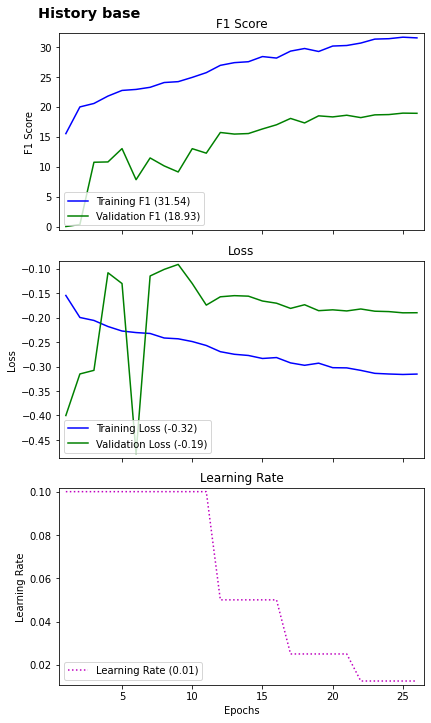

In [4]:
### Baseline Model Training
epochs = 50

# Get timer for baseline training
base_start = time.perf_counter()

# Prepare Baseline Folder
base_folder = os.path.join(test_dir, 'baseline')
if not os.path.exists(base_folder): os.mkdir(base_folder)

# Prepare tensorboard folder
base_tb_dir = os.path.join(base_folder, 'tensorboard')
    
# Prepare Callbacks, including weight output
base_callbacks = kt.SetCallbacks(weights_out=base_folder+'/BaselineWeights.h5', es_patience = es_patience, rlop_factor = rlop_factor, tensorboard_path=base_tb_dir)
metrics = [kt.dice_coef,'accuracy', kt.f1_score]
    
if use_gpu:
    with mirror_strategy.scope():
        # Select and Build Model
        model = Deeplabv4(224, 224, dropout = 0.2) 
        model.compile(optimizer=Adam(lr=learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss = kt.dice_coef_loss, metrics=metrics)

        # Train Model
        baseline_results = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=base_callbacks)
else:
    # Select and Build Model
    model = Deeplabv4(224, 224, dropout = 0.2) 
    model.compile(optimizer=Adam(lr=learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss = kt.dice_coef_loss, metrics=metrics)

    # Train Model
    baseline_results = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=base_callbacks)

# Save History plot and csv
doc.plot_history(baseline_results, test_dir=base_folder, config_idx='base')

epochs_used = len(baseline_results.history['accuracy'])

    
""" Evaluate Baseline Model Preformance """
print("Baseline Preformance:")
train_rpt = kt.ModelReport(X_train, Y_train, model, 'Training')
val_rpt = kt.ModelReport(X_val, Y_val, model, 'Validation')
test_rpt = kt.ModelReport(X_test, Y_test, model, 'Testing')

print(dt.now().strftime('\n\n%a at %I:%M:%S%p'))


### Part 2: EM Iteration

`Warning`: By proceeding, the EM Iteration will use the model configured above with the parameters already set. Tune the baseline model above as many times as needed before proceeding.

#### Section 1: Configure EM Test with Annotator

In [5]:
seg_class_map_fp = None
preload = False

In [6]:
# Prepare annotator
annotator = Dynamic_Preloading_Annotator(pairs=pairs,                   # Number of pairs to be linearly generated on either side of the source point 
                                         off_dist=off_dist,             # Interval distance that each new pair is generated
                                         interval=interval,             # Inteval at which new candidate groups are generated
                                         min_p=min_probability,         # Minimum valid probability from class map
                                         L=length_weight_value,         # Weight for line distance
                                         weight_buffer=weight_buffer,   # Buffer to apply to candidates when weighting
                                         normalize_full=normalize_full, # Optionally normalize by K^2 instead of K
                                         )

#copy_anno = annotator

# Preload Candidate Data 
if preload:
    if seg_class_map_fp:
        initial_pmap = rio.open(seg_class_map_fp)
    else:
        initial_pmap = kt.Get_Pmap(source_raster=train_raster, pmodel=model, pmap_fp=None)
    print("PRELOADING")
    all_data = annotator.preload_candidates(source_annotation, initial_pmap)
    %store all_data
    #%store annotator
else:
    %store -r all_data
    #%store -r annotator
    
    # Check the annotators for equivalent configuration
    """bad_keys = []
    for key in ['pairs', 'off_dist', 'interval', 'min_p', 'L', 'weight_buffer', 'normalize_full']:
        if (getattr(annotator, key) != getattr(copy_anno, key)):
            bad_keys.append(key)
    if len(bad_keys) > 0:
        raise RuntimeError("Annotators have {} incompatible keys: {}\nCandidates must be regenerated. Configure this in the first block.".format(len(bad_keys),bad_keys))
    
    """
    print("Loaded candidate_data")
    
    
# Prepare performance storage
em_dict = {
    'Name': ['Base'],
    'Test_Data': [test_rpt],
    'Train_Data': [train_rpt],
    'Val_Data': [val_rpt],
    'Line_IoU': [np.round((source_iou*100), 2)],
    'Epochs': [epochs_used],
    'LR': [learning_rate],
    'Training_Time': ['{:.3f} s'.format(time.perf_counter() - base_start)],
    'Update_Time': ['NA'],
}

# Prepare EM iterator index.
EM_iterator = 0

# Prepare storage for top F1 and IoU
top_f1, top_f1_idx = 0, 0
top_iou, top_iou_idx = 0, 0


Loaded candidate_data


In [7]:
buff_dist = 4

em_target = 10

#### Run EM Iteration

Beginning Iteration, Target steps: 10

EM Step 00 begun.
Mon at 11:05:00PM

Generated Predicted Class and Intermediate Feature Maps from previous model. (Step 00)
Mon at 11:05:29PM

Created New Annotation. (Step 00)
Mon at 11:08:02PM

Created Y_train (2792, 224, 224, 1) and Y_val (160, 224, 224, 1). (Step 00)
Mon at 11:08:07PM

New Learning Rate: 0.100000. (Step 00)
*** Building DeepLabv3Plus Network ***
*** Output_Shape => (None, 224, 224, 1) ***

Training model...
INFO:tensorflow:batch_all_reduce: 69 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 69 all-reduces with algorithm = nccl, num_packs = 1
Completed model Training. (Step 00)
Mon at 11:11:36PM


/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 01
 - F1_Score: 44.756
 - Dice_Score: 44.756
 - False_Positives: 9883600.000
 - False_Negatives: 6916800.000
 - Precision: 40.778
 - Recall: 49.594
 - Keras_Precision: 40.778
 - Keras_Recall: 49.594
 - Confusion Matrix: [[9799141   98836]
 [  69168   68055]]

Training Report 01
 - F1_Score: 45.940
 - Dice_Score: 45.940
 - False_Positives: 129440600.000
 - False_Negatives: 813572600.000
 - Precision: 48.069
 - Recall: 43.992
 - Keras_Precision: 60.925
 - Keras_Recall: 19.876
Validation Report 01
 - F1_Score: 35.652
 - Dice_Score: 35.651
 - False_Positives: 7856300.000
 - False_Negatives: 52067300.000
 - Precision: 40.462
 - Recall: 31.864
 - Keras_Precision: 54.992
 - Keras_Recall: 15.566

New Top F1: 44.76

New Top IoU: 21.45

EM Step (00) Complete on Mon at 11:12:01PM
- Annotation IoU:     21.45
	- Source Improvement: +3.20
	- Step Improvement:   +3.20

------ Times ---------------------
- Class Map Generation: 28.912 s
- Annotation Update:    144.058 s
- Model Training

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 02
 - F1_Score: 51.969
 - Dice_Score: 51.968
 - False_Positives: 16234300.000
 - False_Negatives: 3205500.000
 - Precision: 39.314
 - Recall: 76.640
 - Keras_Precision: 39.314
 - Keras_Recall: 76.640
 - Confusion Matrix: [[9735634  162343]
 [  32055  105168]]

Training Report 02
 - F1_Score: 65.426
 - Dice_Score: 65.425
 - False_Positives: 126477600.000
 - False_Negatives: 713285900.000
 - Precision: 60.466
 - Recall: 71.273
 - Keras_Precision: 70.316
 - Keras_Recall: 29.579
Validation Report 02
 - F1_Score: 47.614
 - Dice_Score: 47.616
 - False_Positives: 9229700.000
 - False_Negatives: 47785600.000
 - Precision: 46.908
 - Recall: 48.341
 - Keras_Precision: 59.291
 - Keras_Recall: 21.955

New Top F1: 51.97

New Top IoU: 26.74

EM Step (01) Complete on Mon at 11:22:32PM
- Annotation IoU:     26.74
	- Source Improvement: +8.48
	- Step Improvement:   +5.28

------ Times ---------------------
- Class Map Generation: 30.923 s
- Annotation Update:    142.142 s
- Model Trainin

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 03
 - F1_Score: 53.923
 - Dice_Score: 53.918
 - False_Positives: 14232000.000
 - False_Negatives: 3403200.000
 - Precision: 42.031
 - Recall: 75.199
 - Keras_Precision: 42.031
 - Keras_Recall: 75.199
 - Confusion Matrix: [[9755657  142320]
 [  34032  103191]]

Training Report 03
 - F1_Score: 68.228
 - Dice_Score: 68.227
 - False_Positives: 103194900.000
 - False_Negatives: 718917400.000
 - Precision: 65.223
 - Recall: 71.523
 - Keras_Precision: 73.895
 - Keras_Recall: 28.892
Validation Report 03
 - F1_Score: 52.958
 - Dice_Score: 52.957
 - False_Positives: 7008900.000
 - False_Negatives: 48095300.000
 - Precision: 55.187
 - Recall: 50.902
 - Keras_Precision: 66.388
 - Keras_Recall: 22.351

New Top F1: 53.92

New Top IoU: 29.20

EM Step (02) Complete on Mon at 11:32:23PM
- Annotation IoU:     29.20
	- Source Improvement: +10.94
	- Step Improvement:   +2.46

------ Times ---------------------
- Class Map Generation: 24.862 s
- Annotation Update:    142.011 s
- Model Traini

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 04
 - F1_Score: 57.154
 - Dice_Score: 57.153
 - False_Positives: 14220400.000
 - False_Negatives: 2542100.000
 - Precision: 44.015
 - Recall: 81.475
 - Keras_Precision: 44.015
 - Keras_Recall: 81.475
 - Confusion Matrix: [[9755773  142204]
 [  25421  111802]]

Training Report 04
 - F1_Score: 69.874
 - Dice_Score: 69.875
 - False_Positives: 90575700.000
 - False_Negatives: 721697600.000
 - Precision: 68.209
 - Recall: 71.623
 - Keras_Precision: 75.977
 - Keras_Recall: 28.414
Validation Report 04
 - F1_Score: 55.593
 - Dice_Score: 55.582
 - False_Positives: 6931300.000
 - False_Negatives: 47866500.000
 - Precision: 57.710
 - Recall: 53.625
 - Keras_Precision: 67.216
 - Keras_Recall: 22.893

New Top F1: 57.15

New Top IoU: 30.51

EM Step (03) Complete on Mon at 11:42:20PM
- Annotation IoU:     30.51
	- Source Improvement: +12.25
	- Step Improvement:   +1.32

------ Times ---------------------
- Class Map Generation: 28.305 s
- Annotation Update:    142.513 s
- Model Trainin

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 05
 - F1_Score: 58.265
 - Dice_Score: 58.271
 - False_Positives: 13070900.000
 - False_Negatives: 2708000.000
 - Precision: 45.731
 - Recall: 80.266
 - Keras_Precision: 45.731
 - Keras_Recall: 80.266
 - Confusion Matrix: [[9767268  130709]
 [  27080  110143]]

Training Report 05
 - F1_Score: 69.922
 - Dice_Score: 69.922
 - False_Positives: 94490900.000
 - False_Negatives: 727493600.000
 - Precision: 68.035
 - Recall: 71.917
 - Keras_Precision: 75.730
 - Keras_Recall: 28.840
Validation Report 05
 - F1_Score: 57.727
 - Dice_Score: 57.728
 - False_Positives: 6370200.000
 - False_Negatives: 48859400.000
 - Precision: 60.853
 - Recall: 54.906
 - Keras_Precision: 69.590
 - Keras_Recall: 22.980

New Top F1: 58.27

New Top IoU: 31.42

EM Step (04) Complete on Mon at 11:50:56PM
- Annotation IoU:     31.42
	- Source Improvement: +13.16
	- Step Improvement:   +0.90

------ Times ---------------------
- Class Map Generation: 24.816 s
- Annotation Update:    142.960 s
- Model Trainin

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 06
 - F1_Score: 58.407
 - Dice_Score: 58.406
 - False_Positives: 11527800.000
 - False_Negatives: 3306700.000
 - Precision: 47.466
 - Recall: 75.903
 - Keras_Precision: 47.466
 - Keras_Recall: 75.903
 - Confusion Matrix: [[9782699  115278]
 [  33067  104156]]

Training Report 06
 - F1_Score: 73.419
 - Dice_Score: 73.418
 - False_Positives: 78164600.000
 - False_Negatives: 713351900.000
 - Precision: 72.146
 - Recall: 74.739
 - Keras_Precision: 78.919
 - Keras_Recall: 29.088
Validation Report 06
 - F1_Score: 56.620
 - Dice_Score: 56.611
 - False_Positives: 5761200.000
 - False_Negatives: 48610700.000
 - Precision: 61.616
 - Recall: 52.374
 - Keras_Precision: 69.858
 - Keras_Recall: 21.549

New Top F1: 58.41

New Top IoU: 32.41

EM Step (05) Complete on Tue at 12:02:09AM
- Annotation IoU:     32.41
	- Source Improvement: +14.15
	- Step Improvement:   +0.99

------ Times ---------------------
- Class Map Generation: 25.473 s
- Annotation Update:    142.841 s
- Model Trainin

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 07
 - F1_Score: 56.110
 - Dice_Score: 56.114
 - False_Positives: 12775700.000
 - False_Negatives: 3389500.000
 - Precision: 44.714
 - Recall: 75.299
 - Keras_Precision: 44.714
 - Keras_Recall: 75.299
 - Confusion Matrix: [[9770220  127757]
 [  33895  103328]]

Training Report 07
 - F1_Score: 71.160
 - Dice_Score: 71.158
 - False_Positives: 82389500.000
 - False_Negatives: 723263300.000
 - Precision: 70.251
 - Recall: 72.092
 - Keras_Precision: 77.682
 - Keras_Recall: 28.392
Validation Report 07
 - F1_Score: 57.347
 - Dice_Score: 57.347
 - False_Positives: 5125500.000
 - False_Negatives: 48455100.000
 - Precision: 63.408
 - Recall: 52.343
 - Keras_Precision: 72.418
 - Keras_Recall: 21.736

EM Step (06) Complete on Tue at 12:11:21AM
- Annotation IoU:     31.94
	- Source Improvement: +13.69
	- Step Improvement:   -0.46

------ Times ---------------------
- Class Map Generation: 25.387 s
- Annotation Update:    142.289 s
- Model Training:       341.753 s
- Model Evaluation: 

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 08
 - F1_Score: 56.336
 - Dice_Score: 56.331
 - False_Positives: 13192800.000
 - False_Negatives: 3167900.000
 - Precision: 44.445
 - Recall: 76.914
 - Keras_Precision: 44.445
 - Keras_Recall: 76.914
 - Confusion Matrix: [[9766049  131928]
 [  31679  105544]]

Training Report 08
 - F1_Score: 70.028
 - Dice_Score: 70.027
 - False_Positives: 90961200.000
 - False_Negatives: 720741500.000
 - Precision: 68.334
 - Recall: 71.808
 - Keras_Precision: 75.979
 - Keras_Recall: 28.530
Validation Report 08
 - F1_Score: 55.606
 - Dice_Score: 55.604
 - False_Positives: 6868600.000
 - False_Negatives: 47671300.000
 - Precision: 57.722
 - Recall: 53.640
 - Keras_Precision: 67.328
 - Keras_Recall: 22.894

EM Step (07) Complete on Tue at 12:21:19AM
- Annotation IoU:     30.95
	- Source Improvement: +12.69
	- Step Improvement:   -1.00

------ Times ---------------------
- Class Map Generation: 28.943 s
- Annotation Update:    141.793 s
- Model Training:       385.569 s
- Model Evaluation: 

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 09
 - F1_Score: 53.353
 - Dice_Score: 53.358
 - False_Positives: 11345300.000
 - False_Negatives: 4602200.000
 - Precision: 44.564
 - Recall: 66.462
 - Keras_Precision: 44.564
 - Keras_Recall: 66.462
 - Confusion Matrix: [[9784524  113453]
 [  46022   91201]]

Training Report 09
 - F1_Score: 64.629
 - Dice_Score: 64.630
 - False_Positives: 101153700.000
 - False_Negatives: 739457000.000
 - Precision: 63.760
 - Recall: 65.523
 - Keras_Precision: 72.592
 - Keras_Recall: 26.595
Validation Report 09
 - F1_Score: 54.825
 - Dice_Score: 54.822
 - False_Positives: 6547100.000
 - False_Negatives: 48211700.000
 - Precision: 57.975
 - Recall: 52.000
 - Keras_Precision: 67.408
 - Keras_Recall: 21.928

EM Step (08) Complete on Tue at 12:28:20AM
- Annotation IoU:     30.80
	- Source Improvement: +12.54
	- Step Improvement:   -0.15

------ Times ---------------------
- Class Map Generation: 26.657 s
- Annotation Update:    142.128 s
- Model Training:       211.702 s
- Model Evaluation:

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 10
 - F1_Score: 56.341
 - Dice_Score: 56.351
 - False_Positives: 13798600.000
 - False_Negatives: 2928900.000
 - Precision: 43.890
 - Recall: 78.656
 - Keras_Precision: 43.890
 - Keras_Recall: 78.656
 - Confusion Matrix: [[9759991  137986]
 [  29289  107934]]

Training Report 10
 - F1_Score: 73.308
 - Dice_Score: 73.306
 - False_Positives: 81890900.000
 - False_Negatives: 716853800.000
 - Precision: 71.703
 - Recall: 74.986
 - Keras_Precision: 78.456
 - Keras_Recall: 29.379
Validation Report 10
 - F1_Score: 61.449
 - Dice_Score: 61.443
 - False_Positives: 5502500.000
 - False_Negatives: 47037300.000
 - Precision: 64.543
 - Recall: 58.638
 - Keras_Precision: 73.404
 - Keras_Recall: 24.406

New Top IoU: 33.46

EM Step (09) Complete on Tue at 12:38:44AM
- Annotation IoU:     33.46
	- Source Improvement: +15.20
	- Step Improvement:   +2.66

------ Times ---------------------
- Class Map Generation: 28.069 s
- Annotation Update:    144.634 s
- Model Training:       411.434 s


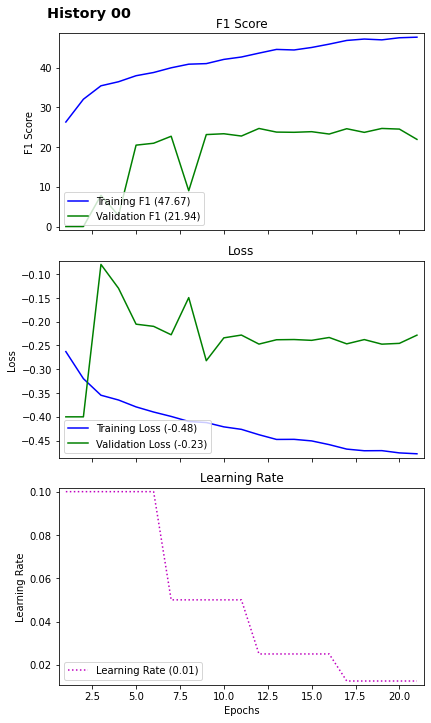

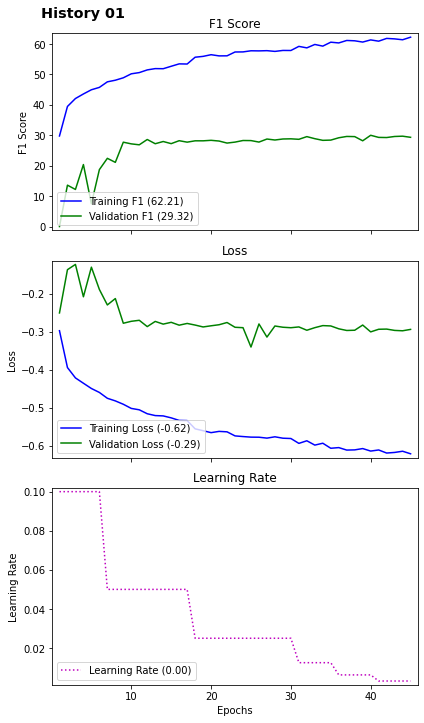

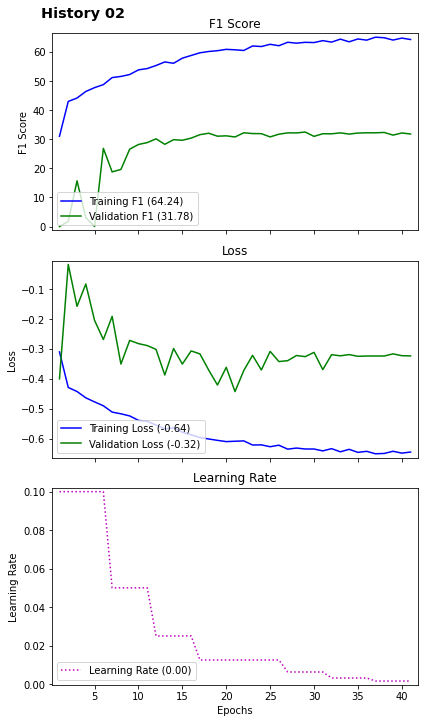

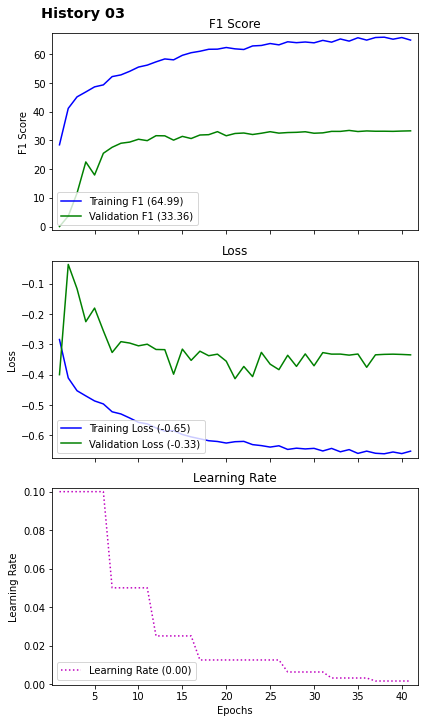

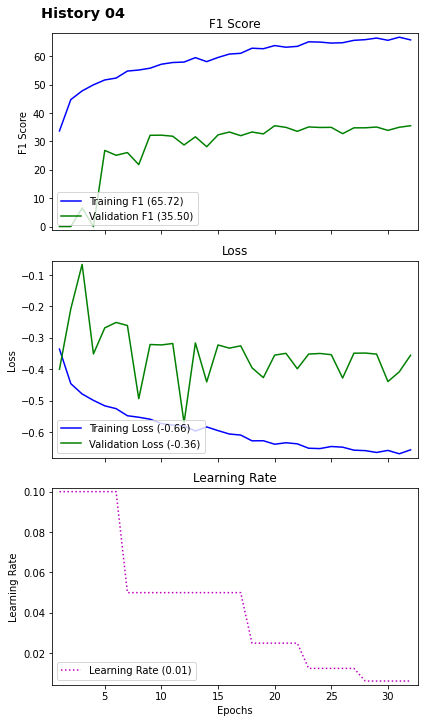

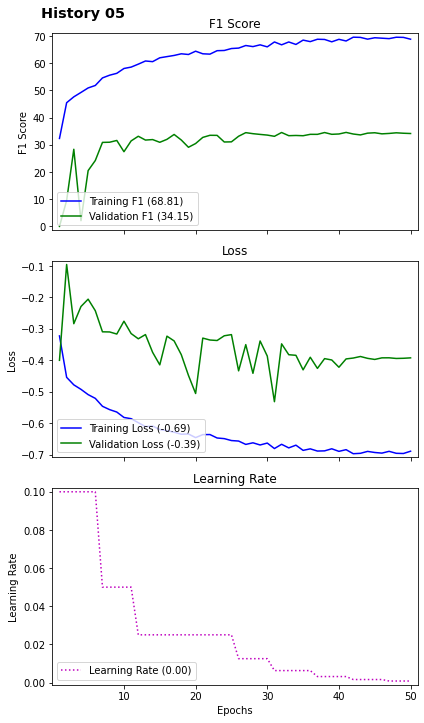

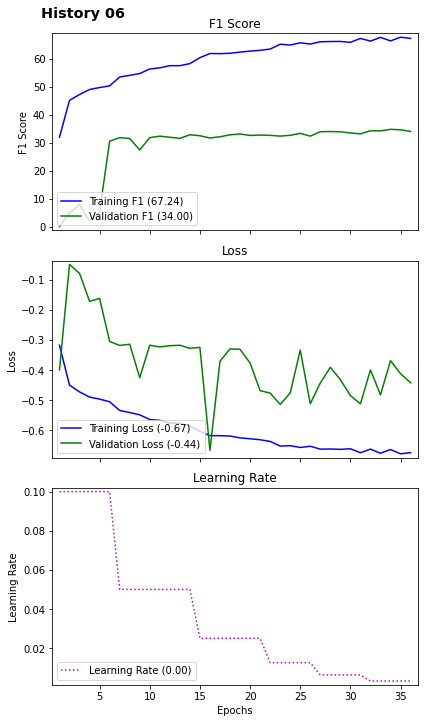

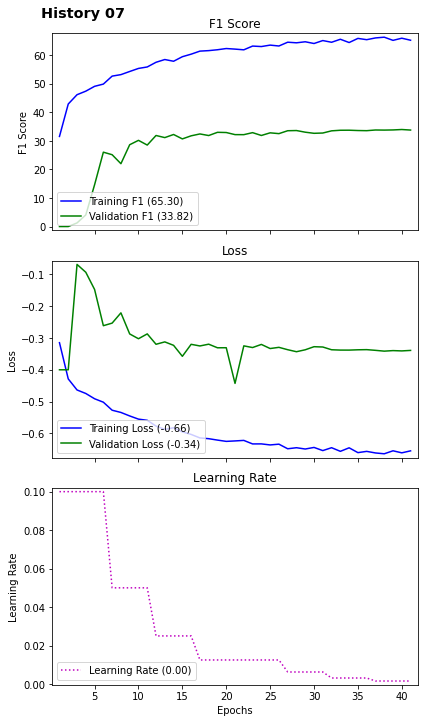

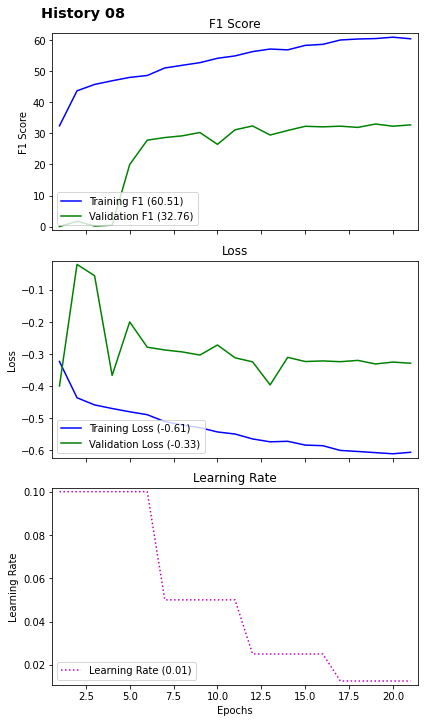

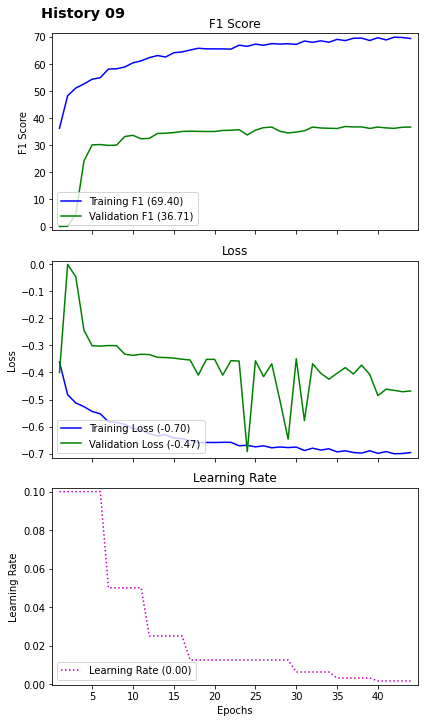

In [8]:
print("Beginning Iteration, Target steps:", em_target)
if EM_iterator > 0: print("Current Step:", EM_iterator)

# -----------------------------------------------------------------------------
# Begin Iteration -------------------------------------------------------------
while EM_iterator < em_target: # Note: using while loop to enable additional runs after test conclusion
    
    # 0. Initialization
    # ---------------------------
    step_start = time.perf_counter()

    # Create folder for em step
    emfolder = os.path.join(test_dir, 'Step_{:02}'.format(EM_iterator))
    if not os.path.exists(emfolder): os.mkdir(emfolder)

    print("\nEM Step {:02} begun.".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))

    
    # 1. Update Annotations
    # ---------------------------

    # 1.1 Get probability output map from last model 
    if (EM_iterator == 0) and seg_class_map_fp:
        # If on the first EM step, we load from previous data
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_baseline.tif')
        kt.Get_Pmap(train_raster, model, pmap_fp)
        predicted_class_map = rio.open(seg_class_map_fp)
    else:
        # On every other EM step we take the pmap from the last model 
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_{:02}.tif'.format(EM_iterator))
        predicted_class_map = kt.Get_Pmap(train_raster, model, pmap_fp)
        
    print("\nGenerated Predicted Class and Intermediate Feature Maps from previous model. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
        
    # 1.2 Update annotation
    update_start = time.perf_counter()
    annotation_fp = os.path.join(emfolder, 'annotation_{:02}.shp'.format(EM_iterator))
    new_annotation = annotator.update_gdf_from_preload(all_data, class_map=predicted_class_map, out_path=annotation_fp) 

    # 1.3 Generate and save all considered point groups
    candidate_start = time.perf_counter()
    candidate_fp = os.path.join(emfolder, 'candidates_{:02}.shp'.format(EM_iterator))
    annotator.get_candidates(source_annotation, class_map=predicted_class_map, out_path=candidate_fp)
    
    # 1.5 Save iou for this annotation.
    iou_start = time.perf_counter()
    anno_iou = gt.gdf_iou(gt_labels, new_annotation, iou_buffer)


    print("\nCreated New Annotation. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))


    # 2. Create new Label Tensors
    # ---------------------------
    
    # 2.1 Rasterize New Labels
    rasterize_start = time.perf_counter()
    buff_anno = gt.gdf_buffer(new_annotation, buff_dist=buff_dist, flatten=True)
    anno_raster_fp = os.path.join(emfolder, 'rasterized_annotation_{:02}.tif'.format(EM_iterator))
    anno_raster = gt.GDF_Rasterize(buff_anno, train_raster, out_path=anno_raster_fp)
    
    # 2.2 Read Y_train, Y_val
    sample_tensor_start = time.perf_counter()
    Y_train = tile.ResampleTiles(anno_raster, train_offsets_fp)
    Y_val = tile.ResampleTiles(anno_raster, val_offsets_fp)
    
    # 2.2 Augment Y_train, Y_val
    Y_train = tile.AugmentImages(Y_train)
    Y_val = tile.AugmentImages(Y_val)
    
    print("\nCreated Y_train {} and Y_val {}. (Step {:02})".format(Y_train.shape, Y_val.shape, EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
    
    # 3. Re-Train U-Net 
    # ---------------------------
    
    # 3.1 Load Callbacks 
    weight_path = os.path.join(emfolder, 'unet_weights_{:02}.h5'.format(EM_iterator))
    tensorboard_path = os.path.join(emfolder, 'tensorboard_{:02}'.format(EM_iterator))
    callbacks =  kt.SetCallbacks(weights_out = weight_path, es_patience = es_patience, rlop_factor = rlop_factor, tensorboard_path = tensorboard_path)#kt.SetCallbacks(emfolder + '/{}_{:02}.h5'.format(model_key, EM_iterator))
    
    # 3.2 Determine Learning Rate from internal oscilator
    EM_learning_rate = learning_rate #lr_schedule(learning_rate, EM_iterator, em_target)
    print("\nNew Learning Rate: {:.6f}. (Step {:02})".format(EM_learning_rate, EM_iterator))
    
    # 3.3 Train Model
    
    model_training_start = time.perf_counter()
    if use_gpu:
        with mirror_strategy.scope():
            model = Deeplabv4(224, 224, dropout = 0.2)
            model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
            print("\nTraining model...")
            training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    else:
        model = Deeplabv4(224, 224, dropout = 0.2)
        model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
        print("\nTraining model...")
        training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    
     
    
    print("Completed model Training. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    


    # 4. Evaluate Model
    # ---------------------------
    
    evaluate_start = time.perf_counter()

    # Save History Plots and CSV
    doc.plot_history(training_history, test_dir=emfolder, config_idx = EM_iterator)
    
    hist_markdown_fp = os.path.join(emfolder, 'history_{:02}.md'.format(EM_iterator))
    hist_md = open(hist_markdown_fp, 'w+')
    
    # Each of the reports below contains a dict with 'F1_Score', 'Dice' and their original floats
    test_rpt = kt.ModelReport(X_test, Y_test, model, "Testing", index=(EM_iterator+1), report_md=hist_md)
    train_rpt = kt.ModelReport(X_train, Y_train, model, "Training", index=(EM_iterator+1), report_md=hist_md)
    val_rpt = kt.ModelReport(X_val, Y_val, model, "Validation", index=(EM_iterator+1), report_md=hist_md)
    
    hist_md.close()
    
    evaluate_end = time.perf_counter()
    
    # Update reference dict
    em_dict['Name'].append('Step {:02}'.format(EM_iterator))
    em_dict['Line_IoU'].append(np.round((anno_iou*100), 2))
    
    em_dict['Test_Data'].append(test_rpt)
    em_dict['Train_Data'].append(train_rpt)
    em_dict['Val_Data'].append(val_rpt)
        
    em_dict['Epochs'].append(len(training_history.history['accuracy']))
    em_dict['LR'].append(EM_learning_rate)
    em_dict['Update_Time'].append('{:.3f} s'.format(candidate_start - update_start))
    em_dict['Training_Time'].append('{:.3f} s'.format(evaluate_start - model_training_start))
    
    
    # Update top values
    ### f1 score
    if test_rpt['F1_Score'] > top_f1:
        top_f1 = test_rpt['F1_Score']
        top_f1_idx = EM_iterator
        print("\nNew Top F1: {:.2f}".format(top_f1*100))
    ### Annotation IoU
    if np.round((anno_iou*100), 2) > top_iou:
        top_iou = np.round((anno_iou*100), 2)
        top_iou_idx = EM_iterator
        print("\nNew Top IoU: {:.2f}".format(top_iou))
    
    # Print step data
    print("\nEM Step ({:02}) Complete on {}".format(EM_iterator, dt.now().strftime('%a at %I:%M:%S%p')))
    print('- Annotation IoU:     {:.2f}'.format(anno_iou*100))
    print('\t- Source Improvement: {:+.2f}'.format((anno_iou-source_iou)*100))
    print('\t- Step Improvement:   {:+.2f}'.format((anno_iou-prev_iou)*100))
    print()
    print("------ Times ---------------------")
    print("- Class Map Generation: {:.3f} s".format(update_start - class_map_start))
    print("- Annotation Update:    {:.3f} s".format(candidate_start - update_start))
    print("- Model Training:       {:.3f} s".format(evaluate_start - model_training_start))
    print("- Model Evaluation:     {:.3f} s".format(evaluate_end - evaluate_start))
    print("----------------------------------\n\n")
    
    # Increase iterator and save previous precision for step_delta
    EM_iterator += 1
    prev_iou = anno_iou
 
# Increase EM target for optional subsequent runs
em_target += 1


Beginning Iteration, Target steps: 14
Current Step: 10

EM Step 10 begun.
Tue at 12:51:25PM

Generated Predicted Class and Intermediate Feature Maps from previous model. (Step 10)
Tue at 12:51:51PM

Created New Annotation. (Step 10)
Tue at 12:54:24PM

Created Y_train (2792, 224, 224, 1) and Y_val (160, 224, 224, 1). (Step 10)
Tue at 12:54:29PM

New Learning Rate: 0.100000. (Step 10)
Preparing UNET model...
UNET model built successfully.

Training model...
Completed model Training. (Step 10)
Tue at 01:02:34PM


/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 11
 - F1_Score: 59.780
 - Dice_Score: 59.773
 - False_Positives: 9331500.000
 - False_Negatives: 3893800.000
 - Precision: 51.297
 - Recall: 71.624
 - Keras_Precision: 51.297
 - Keras_Recall: 71.624
 - Confusion Matrix: [[9804662   93315]
 [  38938   98285]]

Training Report 11
 - F1_Score: 64.889
 - Dice_Score: 64.888
 - False_Positives: 82687700.000
 - False_Negatives: 718682800.000
 - Precision: 63.393
 - Recall: 66.457
 - Keras_Precision: 72.038
 - Keras_Recall: 22.864
Validation Report 11
 - F1_Score: 54.595
 - Dice_Score: 54.593
 - False_Positives: 5853800.000
 - False_Negatives: 46029300.000
 - Precision: 55.547
 - Recall: 53.676
 - Keras_Precision: 65.418
 - Keras_Recall: 19.392

New Top F1: 59.78

EM Step (10) Complete on Tue at 01:03:00PM
- Annotation IoU:     32.93
	- Source Improvement: +14.67
	- Step Improvement:   -0.53

------ Times ---------------------
- Class Map Generation: 25.281 s
- Annotation Update:    143.955 s
- Model Training:       484.943 s
- 

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 12
 - F1_Score: 58.893
 - Dice_Score: 58.888
 - False_Positives: 6728200.000
 - False_Negatives: 5186900.000
 - Precision: 55.920
 - Recall: 62.201
 - Keras_Precision: 55.920
 - Keras_Recall: 62.201
 - Confusion Matrix: [[9830695   67282]
 [  51869   85354]]

Training Report 12
 - F1_Score: 72.697
 - Dice_Score: 72.696
 - False_Positives: 44642600.000
 - False_Negatives: 720245800.000
 - Precision: 76.605
 - Recall: 69.168
 - Keras_Precision: 82.129
 - Keras_Recall: 22.169
Validation Report 12
 - F1_Score: 59.475
 - Dice_Score: 59.474
 - False_Positives: 3472000.000
 - False_Negatives: 46808800.000
 - Precision: 67.588
 - Recall: 53.101
 - Keras_Precision: 74.983
 - Keras_Recall: 18.188

New Top IoU: 35.24

EM Step (11) Complete on Tue at 01:14:17PM
- Annotation IoU:     35.24
	- Source Improvement: +16.98
	- Step Improvement:   +2.31

------ Times ---------------------
- Class Map Generation: 26.105 s
- Annotation Update:    141.533 s
- Model Training:       469.450 s
-

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 13
 - F1_Score: 63.195
 - Dice_Score: 63.185
 - False_Positives: 6985200.000
 - False_Negatives: 4156800.000
 - Precision: 57.795
 - Recall: 69.708
 - Keras_Precision: 57.795
 - Keras_Recall: 69.708
 - Confusion Matrix: [[9828125   69852]
 [  41568   95655]]

Training Report 13
 - F1_Score: 76.261
 - Dice_Score: 76.260
 - False_Positives: 40116400.000
 - False_Negatives: 710285800.000
 - Precision: 79.528
 - Recall: 73.251
 - Keras_Precision: 84.294
 - Keras_Recall: 23.261
Validation Report 13
 - F1_Score: 66.308
 - Dice_Score: 66.311
 - False_Positives: 2506200.000
 - False_Negatives: 46057300.000
 - Precision: 76.096
 - Recall: 58.751
 - Keras_Precision: 81.609
 - Keras_Recall: 19.450

New Top F1: 63.19

New Top IoU: 36.29

EM Step (12) Complete on Tue at 01:28:08PM
- Annotation IoU:     36.29
	- Source Improvement: +18.04
	- Step Improvement:   +1.05

------ Times ---------------------
- Class Map Generation: 26.057 s
- Annotation Update:    142.612 s
- Model Training

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 14
 - F1_Score: 64.030
 - Dice_Score: 64.026
 - False_Positives: 8538800.000
 - False_Negatives: 3239200.000
 - Precision: 55.111
 - Recall: 76.395
 - Keras_Precision: 55.111
 - Keras_Recall: 76.395
 - Confusion Matrix: [[9812589   85388]
 [  32392  104831]]

Training Report 14
 - F1_Score: 75.710
 - Dice_Score: 75.709
 - False_Positives: 47389700.000
 - False_Negatives: 703893700.000
 - Precision: 76.968
 - Recall: 74.492
 - Keras_Precision: 82.356
 - Keras_Recall: 23.911
Validation Report 14
 - F1_Score: 62.716
 - Dice_Score: 62.717
 - False_Positives: 3596000.000
 - False_Negatives: 46057700.000
 - Precision: 69.163
 - Recall: 57.368
 - Keras_Precision: 75.166
 - Keras_Recall: 19.114

New Top F1: 64.03

EM Step (13) Complete on Tue at 01:42:10PM
- Annotation IoU:     35.81
	- Source Improvement: +17.55
	- Step Improvement:   -0.48

------ Times ---------------------
- Class Map Generation: 29.060 s
- Annotation Update:    142.125 s
- Model Training:       631.549 s
- 

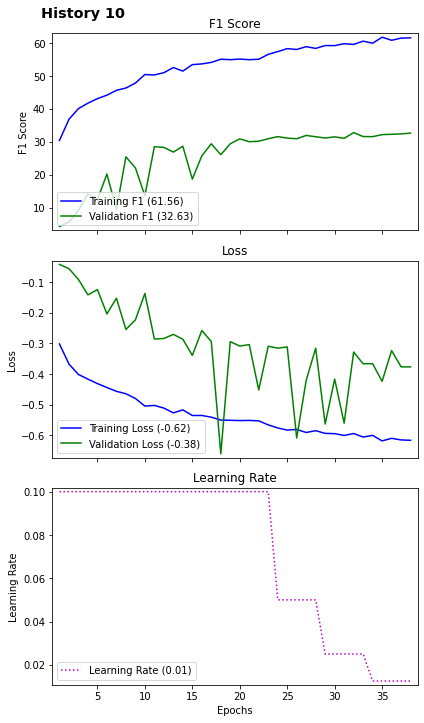

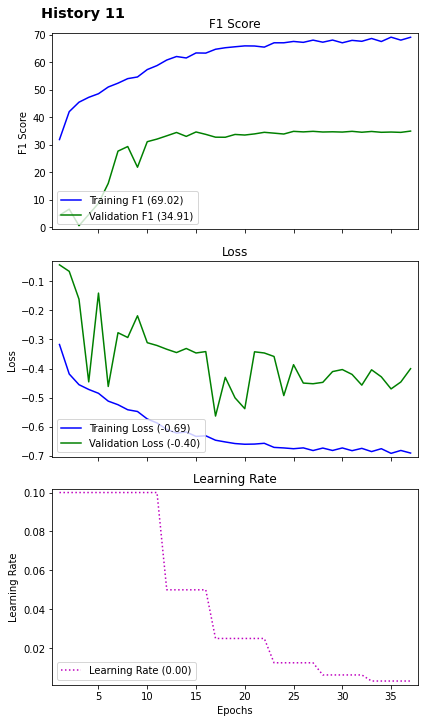

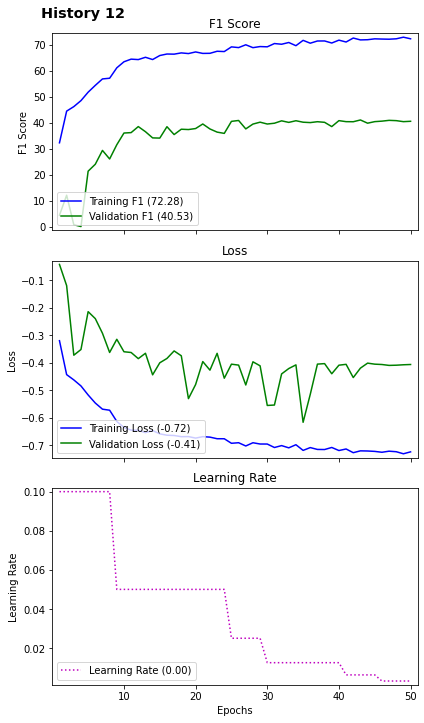

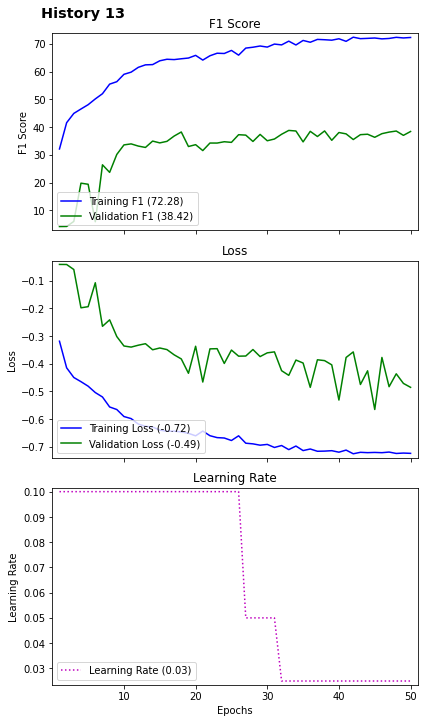

In [9]:
em_target = 14
buff_dist = 3

print("Beginning Iteration, Target steps:", em_target)
if EM_iterator > 0: print("Current Step:", EM_iterator)

# -----------------------------------------------------------------------------
# Begin Iteration -------------------------------------------------------------
while EM_iterator < em_target: # Note: using while loop to enable additional runs after test conclusion
    
    # 0. Initialization
    # ---------------------------
    step_start = time.perf_counter()

    # Create folder for em step
    emfolder = os.path.join(test_dir, 'Step_{:02}'.format(EM_iterator))
    if not os.path.exists(emfolder): os.mkdir(emfolder)

    print("\nEM Step {:02} begun.".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))

    
    # 1. Update Annotations
    # ---------------------------

    # 1.1 Get probability output map from last model 
    if (EM_iterator == 0) and seg_class_map_fp:
        # If on the first EM step, we load from previous data
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_baseline.tif')
        kt.Get_Pmap(train_raster, model, pmap_fp)
        predicted_class_map = rio.open(seg_class_map_fp)
    else:
        # On every other EM step we take the pmap from the last model 
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_{:02}.tif'.format(EM_iterator))
        predicted_class_map = kt.Get_Pmap(train_raster, model, pmap_fp)
        
    print("\nGenerated Predicted Class and Intermediate Feature Maps from previous model. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
        
    # 1.2 Update annotation
    update_start = time.perf_counter()
    annotation_fp = os.path.join(emfolder, 'annotation_{:02}.shp'.format(EM_iterator))
    new_annotation = annotator.update_gdf_from_preload(all_data, class_map=predicted_class_map, out_path=annotation_fp) 

    # 1.3 Generate and save all considered point groups
    candidate_start = time.perf_counter()
    candidate_fp = os.path.join(emfolder, 'candidates_{:02}.shp'.format(EM_iterator))
    annotator.get_candidates(source_annotation, class_map=predicted_class_map, out_path=candidate_fp)
    
    # 1.5 Save iou for this annotation.
    iou_start = time.perf_counter()
    anno_iou = gt.gdf_iou(gt_labels, new_annotation, iou_buffer)


    print("\nCreated New Annotation. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))


    # 2. Create new Label Tensors
    # ---------------------------
    
    # 2.1 Rasterize New Labels
    rasterize_start = time.perf_counter()
    buff_anno = gt.gdf_buffer(new_annotation, buff_dist=buff_dist, flatten=True)
    anno_raster_fp = os.path.join(emfolder, 'rasterized_annotation_{:02}.tif'.format(EM_iterator))
    anno_raster = gt.GDF_Rasterize(buff_anno, train_raster, out_path=anno_raster_fp)
    
    # 2.2 Read Y_train, Y_val
    sample_tensor_start = time.perf_counter()
    Y_train = tile.ResampleTiles(anno_raster, train_offsets_fp)
    Y_val = tile.ResampleTiles(anno_raster, val_offsets_fp)
    
    # 2.2 Augment Y_train, Y_val
    Y_train = tile.AugmentImages(Y_train)
    Y_val = tile.AugmentImages(Y_val)
    
    print("\nCreated Y_train {} and Y_val {}. (Step {:02})".format(Y_train.shape, Y_val.shape, EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
    
    # 3. Re-Train U-Net 
    # ---------------------------
    
    # 3.1 Load Callbacks 
    weight_path = os.path.join(emfolder, 'unet_weights_{:02}.h5'.format(EM_iterator))
    tensorboard_path = os.path.join(emfolder, 'tensorboard_{:02}'.format(EM_iterator))
    callbacks =  kt.SetCallbacks(weights_out = weight_path, es_patience = es_patience, rlop_factor = rlop_factor, tensorboard_path = tensorboard_path)#kt.SetCallbacks(emfolder + '/{}_{:02}.h5'.format(model_key, EM_iterator))
    
    # 3.2 Determine Learning Rate from internal oscilator
    EM_learning_rate = learning_rate #lr_schedule(learning_rate, EM_iterator, em_target)
    print("\nNew Learning Rate: {:.6f}. (Step {:02})".format(EM_learning_rate, EM_iterator))
    
    # 3.3 Train Model
    
    model_training_start = time.perf_counter()
    if use_gpu:
        with mirror_strategy.scope():
            model = kt.Get_Model('UNET')
            model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
            print("\nTraining model...")
            training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    else:
        model = kt.Get_Model('UNET')
        model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
        print("\nTraining model...")
        training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    
     
    
    print("Completed model Training. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    


    # 4. Evaluate Model
    # ---------------------------
    
    evaluate_start = time.perf_counter()

    # Save History Plots and CSV
    doc.plot_history(training_history, test_dir=emfolder, config_idx = EM_iterator)
    
    hist_markdown_fp = os.path.join(emfolder, 'history_{:02}.md'.format(EM_iterator))
    hist_md = open(hist_markdown_fp, 'w+')
    
    # Each of the reports below contains a dict with 'F1_Score', 'Dice' and their original floats
    test_rpt = kt.ModelReport(X_test, Y_test, model, "Testing", index=(EM_iterator+1), report_md=hist_md)
    train_rpt = kt.ModelReport(X_train, Y_train, model, "Training", index=(EM_iterator+1), report_md=hist_md)
    val_rpt = kt.ModelReport(X_val, Y_val, model, "Validation", index=(EM_iterator+1), report_md=hist_md)
    
    hist_md.close()
    
    evaluate_end = time.perf_counter()
    
    # Update reference dict
    em_dict['Name'].append('Step {:02}'.format(EM_iterator))
    em_dict['Line_IoU'].append(np.round((anno_iou*100), 2))
    
    em_dict['Test_Data'].append(test_rpt)
    em_dict['Train_Data'].append(train_rpt)
    em_dict['Val_Data'].append(val_rpt)
        
    em_dict['Epochs'].append(len(training_history.history['accuracy']))
    em_dict['LR'].append(EM_learning_rate)
    em_dict['Update_Time'].append('{:.3f} s'.format(candidate_start - update_start))
    em_dict['Training_Time'].append('{:.3f} s'.format(evaluate_start - model_training_start))
    
    
    # Update top values
    ### f1 score
    if test_rpt['F1_Score'] > top_f1:
        top_f1 = test_rpt['F1_Score']
        top_f1_idx = EM_iterator
        print("\nNew Top F1: {:.2f}".format(top_f1*100))
    ### Annotation IoU
    if np.round((anno_iou*100), 2) > top_iou:
        top_iou = np.round((anno_iou*100), 2)
        top_iou_idx = EM_iterator
        print("\nNew Top IoU: {:.2f}".format(top_iou))
    
    # Print step data
    print("\nEM Step ({:02}) Complete on {}".format(EM_iterator, dt.now().strftime('%a at %I:%M:%S%p')))
    print('- Annotation IoU:     {:.2f}'.format(anno_iou*100))
    print('\t- Source Improvement: {:+.2f}'.format((anno_iou-source_iou)*100))
    print('\t- Step Improvement:   {:+.2f}'.format((anno_iou-prev_iou)*100))
    print()
    print("------ Times ---------------------")
    print("- Class Map Generation: {:.3f} s".format(update_start - class_map_start))
    print("- Annotation Update:    {:.3f} s".format(candidate_start - update_start))
    print("- Model Training:       {:.3f} s".format(evaluate_start - model_training_start))
    print("- Model Evaluation:     {:.3f} s".format(evaluate_end - evaluate_start))
    print("----------------------------------\n\n")
    
    # Increase iterator and save previous precision for step_delta
    EM_iterator += 1
    prev_iou = anno_iou
 
# Increase EM target for optional subsequent runs
em_target += 1


Beginning Iteration, Target steps: 16
Current Step: 14

EM Step 14 begun.
Tue at 02:27:51PM

Generated Predicted Class and Intermediate Feature Maps from previous model. (Step 14)
Tue at 02:28:16PM

Created New Annotation. (Step 14)
Tue at 02:30:47PM

Created Y_train (2792, 224, 224, 1) and Y_val (160, 224, 224, 1). (Step 14)
Tue at 02:30:52PM

New Learning Rate: 0.100000. (Step 14)
Preparing UNET model...
UNET model built successfully.

Training model...
Completed model Training. (Step 14)
Tue at 02:37:04PM


/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 15
 - F1_Score: 62.611
 - Dice_Score: 62.618
 - False_Positives: 6672700.000
 - False_Negatives: 4427900.000
 - Precision: 58.210
 - Recall: 67.732
 - Keras_Precision: 58.210
 - Keras_Recall: 67.732
 - Confusion Matrix: [[9831250   66727]
 [  44279   92944]]

Training Report 15
 - F1_Score: 72.306
 - Dice_Score: 72.306
 - False_Positives: 35443100.000
 - False_Negatives: 731195400.000
 - Precision: 79.820
 - Recall: 66.085
 - Keras_Precision: 84.535
 - Keras_Recall: 20.946
Validation Report 15
 - F1_Score: 60.557
 - Dice_Score: 60.549
 - False_Positives: 2602100.000
 - False_Negatives: 47330800.000
 - Precision: 73.314
 - Recall: 51.582
 - Keras_Precision: 79.037
 - Keras_Recall: 17.169

EM Step (14) Complete on Tue at 02:37:31PM
- Annotation IoU:     36.05
	- Source Improvement: +17.80
	- Step Improvement:   +0.24

------ Times ---------------------
- Class Map Generation: 25.719 s
- Annotation Update:    141.597 s
- Model Training:       372.639 s
- Model Evaluation:  

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 16
 - F1_Score: 60.458
 - Dice_Score: 60.452
 - False_Positives: 6526200.000
 - False_Negatives: 4949400.000
 - Precision: 57.343
 - Recall: 63.932
 - Keras_Precision: 57.343
 - Keras_Recall: 63.932
 - Confusion Matrix: [[9832715   65262]
 [  49494   87729]]

Training Report 16
 - F1_Score: 70.681
 - Dice_Score: 70.681
 - False_Positives: 42903400.000
 - False_Negatives: 729445800.000
 - Precision: 76.478
 - Recall: 65.701
 - Keras_Precision: 81.957
 - Keras_Recall: 21.083
Validation Report 16
 - F1_Score: 57.321
 - Dice_Score: 57.323
 - False_Positives: 3066700.000
 - False_Negatives: 47618200.000
 - Precision: 68.588
 - Recall: 49.233
 - Keras_Precision: 75.724
 - Keras_Recall: 16.728

EM Step (15) Complete on Tue at 02:51:08PM
- Annotation IoU:     33.82
	- Source Improvement: +15.56
	- Step Improvement:   -2.24

------ Times ---------------------
- Class Map Generation: 25.563 s
- Annotation Update:    141.229 s
- Model Training:       610.114 s
- Model Evaluation:  

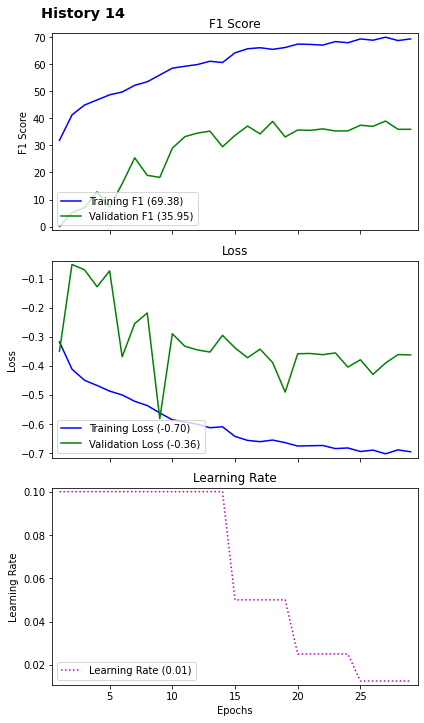

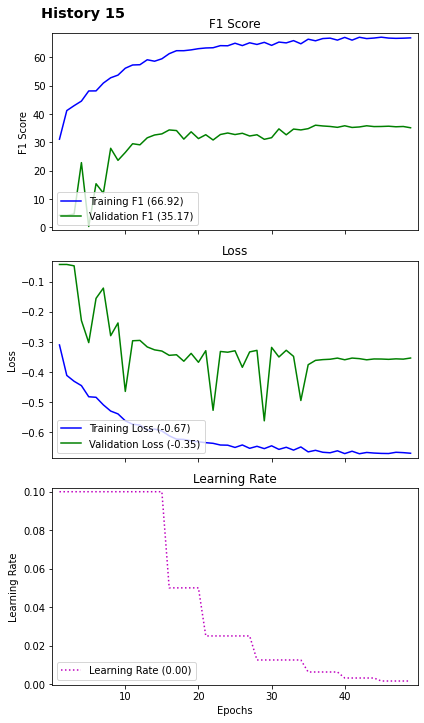

In [10]:
buff_dist = 3

em_target = 16

print("Beginning Iteration, Target steps:", em_target)
if EM_iterator > 0: print("Current Step:", EM_iterator)

# -----------------------------------------------------------------------------
# Begin Iteration -------------------------------------------------------------
while EM_iterator < em_target: # Note: using while loop to enable additional runs after test conclusion
    
    # 0. Initialization
    # ---------------------------
    step_start = time.perf_counter()

    # Create folder for em step
    emfolder = os.path.join(test_dir, 'Step_{:02}'.format(EM_iterator))
    if not os.path.exists(emfolder): os.mkdir(emfolder)

    print("\nEM Step {:02} begun.".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))

    
    # 1. Update Annotations
    # ---------------------------

    # 1.1 Get probability output map from last model 
    if (EM_iterator == 0) and seg_class_map_fp:
        # If on the first EM step, we load from previous data
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_baseline.tif')
        kt.Get_Pmap(train_raster, model, pmap_fp)
        predicted_class_map = rio.open(seg_class_map_fp)
    else:
        # On every other EM step we take the pmap from the last model 
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_{:02}.tif'.format(EM_iterator))
        predicted_class_map = kt.Get_Pmap(train_raster, model, pmap_fp)
        
    print("\nGenerated Predicted Class and Intermediate Feature Maps from previous model. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
        
    # 1.2 Update annotation
    update_start = time.perf_counter()
    annotation_fp = os.path.join(emfolder, 'annotation_{:02}.shp'.format(EM_iterator))
    new_annotation = annotator.update_gdf_from_preload(all_data, class_map=predicted_class_map, out_path=annotation_fp) 

    # 1.3 Generate and save all considered point groups
    candidate_start = time.perf_counter()
    candidate_fp = os.path.join(emfolder, 'candidates_{:02}.shp'.format(EM_iterator))
    annotator.get_candidates(source_annotation, class_map=predicted_class_map, out_path=candidate_fp)
    
    # 1.5 Save iou for this annotation.
    iou_start = time.perf_counter()
    anno_iou = gt.gdf_iou(gt_labels, new_annotation, iou_buffer)


    print("\nCreated New Annotation. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))


    # 2. Create new Label Tensors
    # ---------------------------
    
    # 2.1 Rasterize New Labels
    rasterize_start = time.perf_counter()
    buff_anno = gt.gdf_buffer(new_annotation, buff_dist=buff_dist, flatten=True)
    anno_raster_fp = os.path.join(emfolder, 'rasterized_annotation_{:02}.tif'.format(EM_iterator))
    anno_raster = gt.GDF_Rasterize(buff_anno, train_raster, out_path=anno_raster_fp)
    
    # 2.2 Read Y_train, Y_val
    sample_tensor_start = time.perf_counter()
    Y_train = tile.ResampleTiles(anno_raster, train_offsets_fp)
    Y_val = tile.ResampleTiles(anno_raster, val_offsets_fp)
    
    # 2.2 Augment Y_train, Y_val
    Y_train = tile.AugmentImages(Y_train)
    Y_val = tile.AugmentImages(Y_val)
    
    print("\nCreated Y_train {} and Y_val {}. (Step {:02})".format(Y_train.shape, Y_val.shape, EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
    
    # 3. Re-Train U-Net 
    # ---------------------------
    
    # 3.1 Load Callbacks 
    weight_path = os.path.join(emfolder, 'unet_weights_{:02}.h5'.format(EM_iterator))
    tensorboard_path = os.path.join(emfolder, 'tensorboard_{:02}'.format(EM_iterator))
    callbacks =  kt.SetCallbacks(weights_out = weight_path, es_patience = es_patience, rlop_factor = rlop_factor, tensorboard_path = tensorboard_path)#kt.SetCallbacks(emfolder + '/{}_{:02}.h5'.format(model_key, EM_iterator))
    
    # 3.2 Determine Learning Rate from internal oscilator
    EM_learning_rate = learning_rate #lr_schedule(learning_rate, EM_iterator, em_target)
    print("\nNew Learning Rate: {:.6f}. (Step {:02})".format(EM_learning_rate, EM_iterator))
    
    # 3.3 Train Model
    
    model_training_start = time.perf_counter()
    if use_gpu:
        with mirror_strategy.scope():
            model = kt.Get_Model('UNET')
            model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
            print("\nTraining model...")
            training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    else:
        model = kt.Get_Model('UNET')
        model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
        print("\nTraining model...")
        training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    
     
    
    print("Completed model Training. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    


    # 4. Evaluate Model
    # ---------------------------
    
    evaluate_start = time.perf_counter()

    # Save History Plots and CSV
    doc.plot_history(training_history, test_dir=emfolder, config_idx = EM_iterator)
    
    hist_markdown_fp = os.path.join(emfolder, 'history_{:02}.md'.format(EM_iterator))
    hist_md = open(hist_markdown_fp, 'w+')
    
    # Each of the reports below contains a dict with 'F1_Score', 'Dice' and their original floats
    test_rpt = kt.ModelReport(X_test, Y_test, model, "Testing", index=(EM_iterator+1), report_md=hist_md)
    train_rpt = kt.ModelReport(X_train, Y_train, model, "Training", index=(EM_iterator+1), report_md=hist_md)
    val_rpt = kt.ModelReport(X_val, Y_val, model, "Validation", index=(EM_iterator+1), report_md=hist_md)
    
    hist_md.close()
    
    evaluate_end = time.perf_counter()
    
    # Update reference dict
    em_dict['Name'].append('Step {:02}'.format(EM_iterator))
    em_dict['Line_IoU'].append(np.round((anno_iou*100), 2))
    
    em_dict['Test_Data'].append(test_rpt)
    em_dict['Train_Data'].append(train_rpt)
    em_dict['Val_Data'].append(val_rpt)
        
    em_dict['Epochs'].append(len(training_history.history['accuracy']))
    em_dict['LR'].append(EM_learning_rate)
    em_dict['Update_Time'].append('{:.3f} s'.format(candidate_start - update_start))
    em_dict['Training_Time'].append('{:.3f} s'.format(evaluate_start - model_training_start))
    
    
    # Update top values
    ### f1 score
    if test_rpt['F1_Score'] > top_f1:
        top_f1 = test_rpt['F1_Score']
        top_f1_idx = EM_iterator
        print("\nNew Top F1: {:.2f}".format(top_f1*100))
    ### Annotation IoU
    if np.round((anno_iou*100), 2) > top_iou:
        top_iou = np.round((anno_iou*100), 2)
        top_iou_idx = EM_iterator
        print("\nNew Top IoU: {:.2f}".format(top_iou))
    
    # Print step data
    print("\nEM Step ({:02}) Complete on {}".format(EM_iterator, dt.now().strftime('%a at %I:%M:%S%p')))
    print('- Annotation IoU:     {:.2f}'.format(anno_iou*100))
    print('\t- Source Improvement: {:+.2f}'.format((anno_iou-source_iou)*100))
    print('\t- Step Improvement:   {:+.2f}'.format((anno_iou-prev_iou)*100))
    print()
    print("------ Times ---------------------")
    print("- Class Map Generation: {:.3f} s".format(update_start - class_map_start))
    print("- Annotation Update:    {:.3f} s".format(candidate_start - update_start))
    print("- Model Training:       {:.3f} s".format(evaluate_start - model_training_start))
    print("- Model Evaluation:     {:.3f} s".format(evaluate_end - evaluate_start))
    print("----------------------------------\n\n")
    
    # Increase iterator and save previous precision for step_delta
    EM_iterator += 1
    prev_iou = anno_iou
 
# Increase EM target for optional subsequent runs
em_target += 1

### Create Plots

/home/jiang-ws1/.virtualenvs/geo_errors/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


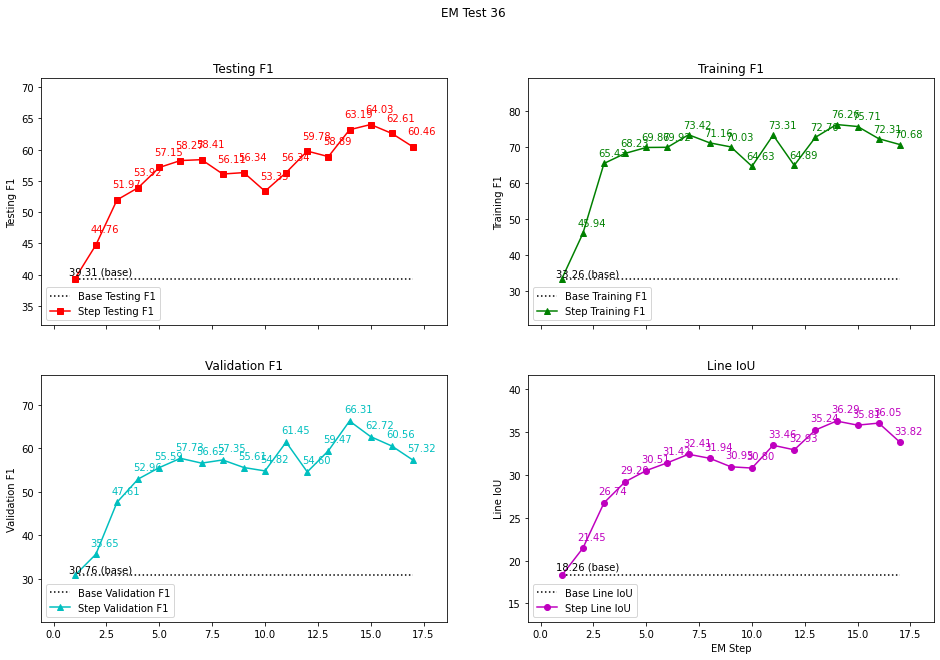

In [11]:
# Clean data for easy indexing

## Converts each of the report lists into a dict of lists for each value
model_dict = {'Test_Data': {}, 'Train_Data': {}, 'Val_Data': {}}
for em_key in model_dict.keys():
    for report in em_dict[em_key]:
        for rpt_key, rpt_value in [(key, item) for key, item in report.items()]:
            if rpt_key not in model_dict[em_key].keys():
                model_dict[em_key].update({rpt_key: np.array([rpt_value])})
            else:
                model_dict[em_key][rpt_key] = np.append(model_dict[em_key][rpt_key], report[rpt_key])


# Create Figure for Plots
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(16,10))

## Plot Testing F1
doc.plot_axis(ax=axs[0,0], 
              data=model_dict['Test_Data']['F1_Score']*100, 
              name='Testing F1', 
              color_char='r', 
              symbol_char='s', 
              y_off=2,
              label_delta=False)

## Plot Training F1
doc.plot_axis(ax=axs[0,1], 
              data=model_dict['Train_Data']['F1_Score']*100, 
              name='Training F1', 
              color_char='g', 
              symbol_char='^', 
              y_off=2,
              label_delta=False)

## Plot Validation F1
doc.plot_axis(ax=axs[1,0], 
              data=model_dict['Val_Data']['F1_Score']*100, 
              name='Validation F1', 
              color_char='c', 
              symbol_char='^', 
              y_off=2,
              label_delta=False)

## Plot Annotation IoU
doc.plot_axis(ax=axs[1,1], 
              data=em_dict['Line_IoU'], 
              name='Line IoU', 
              color_char='m', 
              x_label='EM Step',
              label_delta=False)
    
## Title and show, and save figure
fig.suptitle("EM Test {:02}".format(test_idx))
fig_path = os.path.join(test_dir, 'test_{:02}_plot.png'.format(test_idx))
fig.savefig(fig_path)
fig.show()


### Save to Markdown

Saves:
- Annotator Config
- Model Config
- EM preformance table
- Model preformance table

In [12]:
### Write test data to markdown
markdown_fp = os.path.join(test_dir, 'em_test_info_{:02}.md'.format(test_idx))
md = open(markdown_fp, 'w+')

# Header / Notes
md.write("# EM Test {:02}\n\n".format(test_idx))

if (len(test_notes) > 0):
    md.write("### Notes: \n")
    md.write(test_notes)

md.write(dt.now().strftime('\n%a at %I:%M:%S%p'))
    
md.write("\n\n---\n\n")

# prepare peak values
top_f1 = np.round((top_f1*100), 3)
source_f1 = np.round((em_dict['Test_Data'][0]['F1_Score']*100), 3)
source_iou = np.round(source_iou*100, 2)

# Note at top the peak values 
md.write("### Top Values:\n\n")
md.write(" - Testing F1 Score: **{:.2f}** (`{:+.2f}`) - Step {:02}\n".format(top_f1, (top_f1-source_f1), top_f1_idx))
md.write(" - Annotation IoU: **{:.2f}** (`{:+.2f}`) - Step {:02}\n\n\n".format(top_iou, (top_iou-source_iou), top_iou_idx))



# Test Configuration Section
md.write("## **Test Config**\n\n")

md.write("### Seeds:\n")
md.write("`Python`: {}, `Numpy`: {}, `Tensorflow`: {}\n\n".format(py_seed, np_seed, tf_seed))

md.write("### Annotator:\n")
for key, item in annotator.__dict__.items():
    
    # Skip gross keys
    if key in ['verbosity', 'crop_window', 'class_map', 'kwargs_key', 'crs']:
        continue
    
    # Write key and item
    md.write("- `{}`: {}\n".format(key, item))
        
md.write("\n\n")

md.write("### Model:\n")
md.write("- **Training**:\n")
md.write("  - `Batch Size`: {}\n".format(batch_size))
md.write("  - `Learning Rate`: {}\n".format(learning_rate))
md.write("  - `Epochs`: {}\n".format(epochs))
md.write("- **Callbacks**:\n")
md.write("  - `ES Patience`: {}\n".format(es_patience))
md.write("  - `RLOP Factor`: {}\n".format(rlop_factor))
md.write("  - `Adam Epsilon`: {}\n".format(adam_epsilon))
md.write("  - `Adam Decay`: {}\n".format(adam_decay))

md.write("\n\n")

md.write("### Other:\n")
md.write("- EM Steps: {}\n".format(em_target))
md.write("- ClassMap: '{}'\n".format(seg_class_map_fp))


md.write("\n---\n\n")


# Results Section

md.write("## **Results**:\n\n")

md.write("### EM Iteration:\n\n")

md.write("Step | Anno IoU | F1 | Epochs | LR | Train | Update\n")
md.write("---- | -------- | -- | ------ | -- | ----- | ------\n")
for idx in range(em_target):
    if idx == 0:
        md.write("{} | {} | {} | {} | {} | {} | {}\n".format(em_dict['Name'][idx], em_dict['Line_IoU'][idx], em_dict['Test_Data'][idx]['F1_Score'], em_dict['Epochs'][idx], em_dict['LR'][idx], em_dict['Training_Time'][idx], em_dict['Update_Time'][idx]))
    else:
        md.write("{} | {} (`{:+.2f}`) | {} | {} | {} | {} | {}\n".format(em_dict['Name'][idx], em_dict['Line_IoU'][idx], (em_dict['Line_IoU'][idx] - em_dict['Line_IoU'][0]), em_dict['Test_Data'][idx]['F1_Score'], em_dict['Epochs'][idx], em_dict['LR'][idx], em_dict['Training_Time'][idx], em_dict['Update_Time'][idx]))

md.write("\n\n</br>\n\n")
    
md.write("### Model Performance:\n\n")
md.write("Step | Test F1 | Test (FP, FN) | Train F1 | Train (FP, FN) | Val F1 | Val (FP, FN) | LR \n")
md.write("---- | ------- | ------------- | -------- | -------------- | ------ | ------------ | -- \n")
for idx in range(em_target):
    # Create a string to hold this row's data
    row_string = "{} | ".format(em_dict['Name'][idx])
    
    # Iterate over F1 types
    for key in ['Test_Data', 'Train_Data', 'Val_Data']:
        
        if idx == 0:
            row_string += "{:.2f} | ({:.2e}, {:.2e}) | ".format(em_dict[key][idx]['F1_Score']*100, em_dict[key][idx]['False_Positives'], em_dict[key][idx]['False_Negatives'])
        else:
            row_string += "{:.2f} (`{:+.2f}`) | ({:.2e}, {:.2e}) | ".format(em_dict[key][idx]['F1_Score']*100, (em_dict[key][idx]['F1_Score']*100 - em_dict[key][0]['F1_Score']*100), em_dict[key][idx]['False_Positives'], em_dict[key][idx]['False_Negatives'])
      
    # After all sets have been added, append learning rate and newline
    row_string += "{}\n".format(em_dict['LR'][idx])
    md.write(row_string)


# Close Markdown
md.close()

print("Config and results written to markdown.")
print("Location:", markdown_fp)

Config and results written to markdown.
Location: /data/GeometricErrors/tests/Test_36/em_test_info_36.md
